流程
* Geopanda讀取
    * [fiona - Save Start/End Points in another shapefile using Shapely - Geographic Information Systems Stack Exchange](https://gis.stackexchange.com/questions/203134/save-start-end-points-in-another-shapefile-using-shapely)
* 每一條 polyline為一單位 匯成一個 Array 清單
* 每一條 polyline 所有節點搜尋出來
* 打 API  轉成地址清單
    * https://gist.motc.gov.tw/gist_api/swagger/ui/index
* 將地址清單做個排序篩選出 始末 清單

In [3]:
import geopandas as gpd
roadList=gpd.read_file('./roadInRangeSample.geojson',encoding='utf-8')

In [4]:
roadList.head()

,NAME,ALIAS,CLASS,INDEX,TYPE,RNAME,SNAME,LNAME,ANAME,FACILITY,STOP,LENGTH,geometry
0,精科路,精科路,6,None,1,精科路,None,None,None,None,None,838,"MULTILINESTRING ((120.59991 24.14267, 120.5999..."
1,中台路308巷,中台路308巷,6,None,1,中台路,None,308巷,None,None,None,68,"MULTILINESTRING ((120.59438 24.13933, 120.5943..."
2,建功路256巷,建功路256巷,6,None,1,建功路,None,256巷,None,None,None,84,"MULTILINESTRING ((120.60455 24.13624, 120.6045..."
3,文山路,文山路,6,None,1,文山路,None,None,None,None,None,238,"MULTILINESTRING ((120.60955 24.14451, 120.6093..."
4,精科中一路,精科中一路,6,None,1,精科中一路,None,None,None,None,None,1,"MULTILINESTRING ((120.58986 24.15050, 120.5899..."


In [5]:
roadList.iterrows()

<generator object DataFrame.iterrows at 0x124206650>

(0, NAME                                                      精科路
ALIAS                                                     精科路
CLASS                                                       6
INDEX                                                    None
TYPE                                                        1
RNAME                                                     精科路
SNAME                                                    None
LNAME                                                    None
ANAME                                                    None
FACILITY                                                 None
STOP                                                     None
LENGTH                                                    838

In [6]:
roadList['geometry'][0]
row.geometry.type

NameError: name 'row' is not defined

以此 路段 為例子就包含了 682 條路
其中包含的 節點 可能就有幾萬個

In [ ]:
for i, row in roadList.iterrows():
    print('------------------')
    for polyline in row.geometry:
            print(polyline)

* 一條 multi polyline 包含太多條 line
* 一條 multi polyline 包含了超多節點(800點以上)
* 打 API 會使整個流程相當沒效率
* 透過縮節點嘗試解決
    * 線間的交集點
        * QGIS測試先切出線交集節點進行測試
        * 打 API 轉換成地址
    * 路網 + polygon 交集點
    
    


In [7]:
import geopandas as gpd
lineIsPt=gpd.read_file('./lineIntersecPt.geojson',encoding='utf-8')
lineIsPt.geometry.x.head()
lineIsPt.geometry.y.head()

0    24.142665
1    24.143069
2    24.148021
3    24.142745
4    24.143069
dtype: float64

In [8]:
lineIsPt.head()

,NAME_1,NAME_2,geometry
0,精科路,培德路,POINT (120.59991 24.14267)
1,精科路,精科中路,POINT (120.60111 24.14307)
2,精科路,精科北路,POINT (120.60679 24.14802)
3,精科路,None,POINT (120.60018 24.14274)
4,精科路,精科東路,POINT (120.60111 24.14307)


#### 測試範例
* httplib2 傳送 GET 請求


In [11]:
import httplib2
h = httplib2.Http()
url = 'https://gist.motc.gov.tw/gist_api/V2/Map/GeoCode/Address/23.5,122,5?$format=GEOJSON'
resp, content = h.request(url)
content

b'{"type":"FeatureCollection","features":[{"type":"Feature","geometry":{"type":"Point","coordinates":[121.6045812569886,23.509762481675281]},"properties":{"model":{"Addr":"\xe6\xbe\x8e\xe6\xb9\x96\xe7\xb8\xa3\xe9\xa6\xac\xe5\x85\xac\xe5\xb8\x82\xe5\xb1\xb1\xe6\xb0\xb4\xe9\x87\x8c\xe7\x8f\xa0\xe6\xb1\x9f600\xe8\x99\x9f"}}}]}'

速度非常慢，換另外一套測試

In [ ]:
# 引入 requests 模組
import requests
url = 'https://gist.motc.gov.tw/gist_api/V2/Map/GeoCode/Address/23.5,122,5?$format=GEOJSON'
# 使用 GET 方式下載普通網頁
r = requests.get(url)
print (r)

一樣慢，API應該有阻檔或限制

In [ ]:
# byte 轉 str
str(content, encoding = "utf-8")

#### 實戰

In [328]:
# 引入相關套件
import httplib2
import json
import csv
# 繪圖套件
%matplotlib inline


h = httplib2.Http()

In [ ]:
len(lineIsPt.geometry)

In [ ]:
container = []
for i in range(10):
    x = lineIsPt.geometry.x[i]
    y = lineIsPt.geometry.y[i]
    container.append([y,x])
    
print(container)


In [ ]:
for i in range(10):
    x = str(lineIsPt.geometry.x[i])
    y = str(lineIsPt.geometry.y[i])
    
    xy = y+','+x
    res = f'https://gist.motc.gov.tw/gist_api/V2/Map/GeoCode/Address/{xy}?$format=GEOJSON'
    container.append(res)
    
container

In [72]:
lineIsPt.head()

,NAME_1,NAME_2,geometry
0,精科路,培德路,POINT (120.59991 24.14267)
1,精科路,精科中路,POINT (120.60111 24.14307)
2,精科路,精科北路,POINT (120.60679 24.14802)
3,精科路,None,POINT (120.60018 24.14274)
4,精科路,精科東路,POINT (120.60111 24.14307)


遇到超時問題

引入 socket 解決

```python
socket.setdefaulttimeout(100000000)
```

In [92]:
import httplib2
import json
import socket 
socket.setdefaulttimeout(100000000)

h = httplib2.Http(timeout=None)
container = []

container = []
# for i in range(10):
for i in range(lineIsPt.index.stop):
    x = str(lineIsPt.geometry.x[i])
    y = str(lineIsPt.geometry.y[i])
    xy = y+','+x
    resUrl = f'https://gist.motc.gov.tw/gist_api/V2/Map/GeoCode/Address/{xy}?$format=GEOJSON'
    res, content = h.request(resUrl)
    container.append(json.loads(str(content, encoding = "utf-8")))
    
container

TypeError: 'list' object is not callable

In [95]:
print(len(container))
print(type(container[0]))

444
<class 'dict'>


將 444 個節點計算出來並存成 csv

In [112]:
myResData = []

for i in container:
    myResData.append([
        i['features'][0]['geometry']['coordinates'][0],
        i['features'][0]['geometry']['coordinates'][1],
        i['features'][0]['properties']['model']['Addr']
    ])
print(myResData[0],myResData[-1])
print(type(myResData[0]))

[120.5996308508481, 24.14229158797876, '台中市南屯區春社里培德路7號'] [120.5931833962524, 24.13916223830457, '台中市南屯區春社里中台路317巷2號']
<class 'list'>


In [55]:
for i in myResData:
    print(i[0], i[1], i[2]) 

120.5996308508481 24.14229158797876 台中市南屯區春社里培德路7號
120.6009109336114 24.14252298118082 台中市南屯區春社里精科路2號
120.6062307321551 24.14751725360878 台中市南屯區文山里精科路28號
120.5996308508481 24.14229158797876 台中市南屯區春社里培德路7號
120.6009109336114 24.14252298118082 台中市南屯區春社里精科路2號
120.6062307321551 24.14751725360878 台中市南屯區文山里精科路28號
120.6082305515638 24.14873859268674 台中市南屯區文山里精科路112號
120.5943328215131 24.13940972800623 台中市南屯區春社里中台路310巷1之1號
120.6042334419134 24.136863556312 台中市南屯區春社里建功路256巷22號
120.6042334419134 24.136863556312 台中市南屯區春社里建功路256巷22號


In [113]:
import csv

# 開啟輸出的 CSV 檔案
with open('addressRes.csv', 'w', newline='') as csvfile:
    # 建立 CSV 檔寫入器
    writer = csv.writer(csvfile)
    # 寫入第一列資料
    writer.writerow(['Lon', 'Lat', 'Address'])
    
    #迴圈寫入資料
    for i in myResData:
        writer.writerow([i[0], i[1], i[2]])    

觀察資料歸納

問題
* 有重複地址
* 上下左右等敘述 - 例如地下一層

嘗試透過 shapely + fiona 直接抓取:
* 起始點
* 結束點
* 中間節點
    

In [115]:
from shapely.geometry import Point, shape
import fiona

In [128]:
lines = [shape(line['geometry']) for line in fiona.open("roadInRangeSample.geojson")]
type(lines)

list

In [133]:
for i in lines:
    for line in i:
        print(line)d

SyntaxError: invalid syntax (<ipython-input-133-720fac436119>, line 3)

In [139]:
endpts = [
    (
        Point(list(line.coords)[0]),
        Point(list(line.coords)[-1])
    )
    # 先取出 multiline     
    for multiLines in lines
    # 再從 multiLine 取出各條路
    for line in multiLines
]
# flatten the resulting list to a simple list of points
# endpts= [pt for sublist in endpts  for pt in sublist] 

In [138]:
len(endpts)

682

保存生成的 shp

In [156]:
from shapely.geometry import mapping
# schema of the shapefile
schema = {'geometry': 'Point','properties': {'test': 'int'}}
# creation of the shapefile
with fiona.open('result.shp','w','ESRI Shapefile', schema) as output:
    for i, pt in enumerate(endpts):
        output.write({'geometry':mapping(pt), 'properties':{'test':i}})

AttributeError: 'tuple' object has no attribute '__geo_interface__'

In [145]:
endpts[0]

(<shapely.geometry.point.Point at 0x128965b50>,
 <shapely.geometry.point.Point at 0x1289657d0>)

In [148]:
import itertools
inters = []
for line1,line2 in itertools.combinations(lines, 2):
      if  line1.intersects(line2):
        inter = line1.intersection(line2)
        if "Point" == inter.type:
            inters.append(inter)
        elif "MultiPoint" == inter.type:
            inters.extend([pt for pt in inter])
        elif "MultiLineString" == inter.type:
            multiLine = [line for line in inter]
            first_coords = multiLine[0].coords[0]
            last_coords = multiLine[len(multiLine)-1].coords[1]
            inters.append(Point(first_coords[0], first_coords[1]))
            inters.append(Point(last_coords[0], last_coords[1]))
        elif "GeometryCollection" == inter.type:
            for geom in inter:
                if "Point" == geom.type:
                    inters.append(geom)
                elif "MultiPoint" == geom.type:
                    inters.extend([pt for pt in geom])
                elif "MultiLineString" == geom.type:
                    multiLine = [line for line in geom]
                    first_coords = multiLine[0].coords[0]
                    last_coords = multiLine[len(multiLine)-1].coords[1]
                    inters.append(Point(first_coords[0], first_coords[1]))
                    inters.append(Point(last_coords[0], last_coords[1]))

In [150]:
result = endpts.extend([pt for pt in inters  if pt not in endpts])

In [152]:
print(result)

None


In [126]:
from shapely.geometry import  MultiLineString, mapping, shape
coords = [((0, 0), (1, 1)), ((-1, 0), (1, 0))]
lines = MultiLineString(coords)
print(lines)
# MULTILINESTRING ((0 0, 1 1), (-1 0, 1 0))
for line in lines:
     print(line)
# LINESTRING (0 0, 1 1)
# LINESTRING (-1 0, 1 0)

# convert to GeoJSON format:
print(mapping(lines))
# {'type': 'MultiLineString', 'coordinates': (((0.0, 0.0), (1.0, 1.0)), ((-1.0, 0.0), (1.0, 0.0)))}
# convert from GeoJSON to shapely
print(shape(mapping(lines)))
# MULTILINESTRING ((0 0, 1 1), (-1 0, 1 0))

MULTILINESTRING ((0 0, 1 1), (-1 0, 1 0))
LINESTRING (0 0, 1 1)
LINESTRING (-1 0, 1 0)
{'type': 'MultiLineString', 'coordinates': (((0.0, 0.0), (1.0, 1.0)), ((-1.0, 0.0), (1.0, 0.0)))}
MULTILINESTRING ((0 0, 1 1), (-1 0, 1 0))


=============================================

簡化檔案
* 用單純線嘗試

In [247]:
import geopandas as gpd
singleRoad=gpd.read_file('./singleRoadExample.geojson',encoding='utf-8')

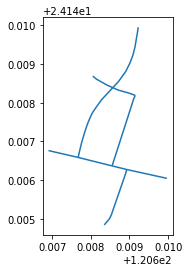

In [248]:
# 檢查形狀
singleRoad.plot()

In [264]:
import geopandas as gpd
lines_geopandas=gpd.read_file('./singleRoadExample.geojson',encoding='utf-8')

print(lines_geopandas.head(3))

# 此時取出的 geometry 就是 shapely 格式
for i in lines_geopandas['geometry'][0]:
    # shapely.geometry.linestring.LineString'
    print(type(i))

   NAME ALIAS  CLASS INDEX  TYPE RNAME SNAME LNAME ANAME FACILITY  STOP  \
0  保安八街  保安八街      6  None     1  保安八街  None  None  None     None  None   
1  保安十街  保安十街      6  None     1  保安十街  None  None  None     None  None   
2  保安九街  保安九街      6  None     1  保安九街  None  None  None     None  None   

   LENGTH                                           geometry  
0     156  MULTILINESTRING ((120.60893 24.14627, 120.6088...  
1     189  MULTILINESTRING ((120.60923 24.14995, 120.6092...  
2     211  MULTILINESTRING ((120.60855 24.14637, 120.6085...  
<class 'shapely.geometry.linestring.LineString'>


In [366]:
from shapely.geometry import Point, shape
import fiona
lines = [[line['properties']['NAME'],shape(line['geometry'])] for line in fiona.open("./singleRoadExample.geojson")]
# 變成 shapely 格式
lines

[['保安八街', <shapely.geometry.multilinestring.MultiLineString at 0x12f0ee790>],
 ['保安十街', <shapely.geometry.multilinestring.MultiLineString at 0x12f0d38d0>],
 ['保安九街', <shapely.geometry.multilinestring.MultiLineString at 0x12f0eee90>],
 ['文山五街', <shapely.geometry.multilinestring.MultiLineString at 0x12d482fd0>],
 ['文山三街', <shapely.geometry.multilinestring.MultiLineString at 0x12f0ee210>]]

geoDataFrames 就是以 Shapely 進行儲存
故這邊繼續以 Shapely 進行處理

轉成 single 並且取出節點

In [261]:
len(lines_geopandas['geometry'])

5

In [351]:
d = 'a'
endpts = [
    (   
        multiLines.NAME,
        # 再加入是哪一條線
        # 每一個起始、終點湊成一條路就是一個單位
        Point(list(line.coords)[0]),
        Point(list(line.coords)[-1])
    )
    # 先取出 multiline     
    for multiLines in lines
    # 再從 multiLine 取出各條路
    for line in multiLines
]

AttributeError: 'MultiLineString' object has no attribute 'NAME'

In [352]:
for multiLines in lines:
    print(multiLines)

MULTILINESTRING ((120.6089309391138 24.14627476778369, 120.6088894441397 24.14614007665966, 120.6085270575645 24.1450908120425, 120.6084816326584 24.14500158661412, 120.6084325808589 24.14494338003758, 120.6083476072613 24.14484254621429))
MULTILINESTRING ((120.609225339832 24.14995443893547, 120.6092094972414 24.14984152087339, 120.6091421603854 24.1494429810566, 120.609085706979 24.14922268592482, 120.6090063565583 24.1490180574732, 120.6089041580466 24.1488133704312, 120.6087164503423 24.14855080506197, 120.6086139643273 24.14844046745538, 120.6085685709055 24.14839187474187, 120.6084716208175 24.14828809384088, 120.6082723458779 24.14807267343719, 120.6081301470253 24.14787312468994, 120.6080448471077 24.14774710546271, 120.6079880765206 24.14763164243848, 120.6079143528693 24.14745585738896, 120.6078407653695 24.14723551775432, 120.6077616100884 24.14696798858157, 120.6076995600824 24.14671098720466, 120.6076729863938 24.14658726584867))
MULTILINESTRING ((120.6085504911976 24.1463

In [350]:
# 取得起始點、結束點
endpts

[(<shapely.geometry.multilinestring.MultiLineString at 0x129a5af90>,
  <shapely.geometry.point.Point at 0x12efa8e10>),
 (<shapely.geometry.multilinestring.MultiLineString at 0x129a5acd0>,
  <shapely.geometry.point.Point at 0x12efc0290>),
 (<shapely.geometry.multilinestring.MultiLineString at 0x129a5a310>,
  <shapely.geometry.point.Point at 0x12efc0f90>),
 (<shapely.geometry.multilinestring.MultiLineString at 0x12a012cd0>,
  <shapely.geometry.point.Point at 0x12efc0210>),
 (<shapely.geometry.multilinestring.MultiLineString at 0x129a5ae90>,
  <shapely.geometry.point.Point at 0x12efc0310>)]

In [238]:
# 取出 shapely 點位坐標

coordinates = []
for i in endpts:
    coordinates.append([i[0].x,i[0].y])
    coordinates.append([i[1].x,i[1].y])
coordinates

[[120.60893093911378, 24.14627476778369],
 [120.60834760726128, 24.144842546214285],
 [120.60922533983198, 24.149954438935467],
 [120.60767298639375, 24.146587265848666],
 [120.60855049119758, 24.146369126242558],
 [120.60914901897948, 24.14819153208347],
 [120.60805121787317, 24.148690360048928],
 [120.60914901897948, 24.14819153208347],
 [120.60690562981665, 24.14676621808642],
 [120.60996721390009, 24.146046885009234]]

查看形狀

In [312]:
# 組成 geo dataframe
for i in endpts:
    

(<shapely.geometry.point.Point object at 0x129a33d90>, <shapely.geometry.point.Point object at 0x129a33550>)
(<shapely.geometry.point.Point object at 0x129a332d0>, <shapely.geometry.point.Point object at 0x129a33890>)
(<shapely.geometry.point.Point object at 0x129a33910>, <shapely.geometry.point.Point object at 0x129a33190>)
(<shapely.geometry.point.Point object at 0x129a338d0>, <shapely.geometry.point.Point object at 0x129a337d0>)
(<shapely.geometry.point.Point object at 0x129a33450>, <shapely.geometry.point.Point object at 0x1299afa10>)


panda DataFrame 新增欄位方式

In [310]:
df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
     'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]})

print(df)
print("=========================")

# 新增欄位
test = pd.DataFrame({
    "City": ["Test"],
    "Country": ["Test"],
    "Latitude":  [132.311],
    "Longitude": [23.243242],
})

df = df.append(test)
print(df)

           City    Country  Latitude  Longitude
0  Buenos Aires  Argentina    -34.58     -58.66
1      Brasilia     Brazil    -15.78     -47.91
2      Santiago      Chile    -33.45     -70.66
3        Bogota   Colombia      4.60     -74.08
4       Caracas  Venezuela     10.48     -66.86
           City    Country  Latitude  Longitude
0  Buenos Aires  Argentina   -34.580 -58.660000
1      Brasilia     Brazil   -15.780 -47.910000
2      Santiago      Chile   -33.450 -70.660000
3        Bogota   Colombia     4.600 -74.080000
4       Caracas  Venezuela    10.480 -66.860000
0          Test       Test   132.311  23.243242


----------------------------------

### 實戰

道路節點資料表結構定義

```python
gpd_test = gpd.GeoDataFrame({
    "Road_Index": index
    "geometry": endpts[0]
})
```

In [338]:
# 組成 道路節點 GeoDataFrame
index = 0
gpd_road_nodes = gpd.GeoDataFrame()

for pt in endpts:
    pt = gpd.GeoDataFrame({
        "Road_Name":
        "Road_Index": index,
        "geometry": pt
    })
    
    gpd_road_nodes = gpd_road_nodes.append(pt)
    index += 1
gpd_road_nodes

,Road_Index,geometry
0,0,POINT (120.60893 24.14627)
1,0,POINT (120.60835 24.14484)
0,1,POINT (120.60923 24.14995)
1,1,POINT (120.60767 24.14659)
0,2,POINT (120.60855 24.14637)
1,2,POINT (120.60915 24.14819)
0,3,POINT (120.60805 24.14869)
1,3,POINT (120.60915 24.14819)
0,4,POINT (120.60691 24.14677)
1,4,POINT (120.60997 24.14605)


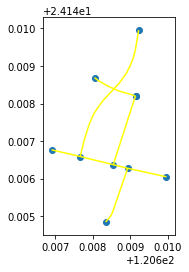

In [339]:
# 檢查形狀
road = singleRoad.plot(color='yellow')
gpd_road_nodes.plot(ax=road)

將原來的路抓出來

In [220]:
points = [
    (
        Point(i),
    )
    for i in coordinates
]

In [221]:
points

[(<shapely.geometry.point.Point at 0x1299995d0>,),
 (<shapely.geometry.point.Point at 0x129999810>,),
 (<shapely.geometry.point.Point at 0x129999650>,),
 (<shapely.geometry.point.Point at 0x12996be10>,),
 (<shapely.geometry.point.Point at 0x1299998d0>,),
 (<shapely.geometry.point.Point at 0x129999c10>,),
 (<shapely.geometry.point.Point at 0x129999b90>,),
 (<shapely.geometry.point.Point at 0x129999c50>,),
 (<shapely.geometry.point.Point at 0x12999f2d0>,),
 (<shapely.geometry.point.Point at 0x1299999d0>,)]

In [235]:
# Insert the polygon into 'geometry' -column at index 0
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import Point, Polygon
# newdata['geometry'] = None
for i in range(len(points)):
    newdata.loc[i, 'geometry'] = points[i]


(<shapely.geometry.point.Point object at 0x1299995d0>,)
(<shapely.geometry.point.Point object at 0x129999810>,)
(<shapely.geometry.point.Point object at 0x129999650>,)
(<shapely.geometry.point.Point object at 0x12996be10>,)
(<shapely.geometry.point.Point object at 0x1299998d0>,)
(<shapely.geometry.point.Point object at 0x129999c10>,)
(<shapely.geometry.point.Point object at 0x129999b90>,)
(<shapely.geometry.point.Point object at 0x129999c50>,)
(<shapely.geometry.point.Point object at 0x12999f2d0>,)
(<shapely.geometry.point.Point object at 0x1299999d0>,)


NameError: name 'GeoDataFrame' is not defined

In [176]:
import itertools
inters = []
for line1,line2 in  itertools.combinations(lines, 2):
      if  line1.intersects(line2):
        inter = line1.intersection(line2)
        if "Point" == inter.type:
            inters.append(inter)
        elif "MultiPoint" == inter.type:
            inters.extend([pt for pt in inter])
        elif "MultiLineString" == inter.type:
            multiLine = [line for line in inter]
            first_coords = multiLine[0].coords[0]
            last_coords = multiLine[len(multiLine)-1].coords[1]
            inters.append(Point(first_coords[0], first_coords[1]))
            inters.append(Point(last_coords[0], last_coords[1]))
        elif "GeometryCollection" == inter.type:
            for geom in inter:
                if "Point" == geom.type:
                    inters.append(geom)
                elif "MultiPoint" == geom.type:
                    inters.extend([pt for pt in geom])
                elif "MultiLineString" == geom.type:
                    multiLine = [line for line in geom]
                    first_coords = multiLine[0].coords[0]
                    last_coords = multiLine[len(multiLine)-1].coords[1]
                    inters.append(Point(first_coords[0], first_coords[1]))
                    inters.append(Point(last_coords[0], last_coords[1]))

In [177]:
inters

In [178]:
result = endpts.extend([pt for pt in inters  if pt not in endpts])

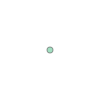

In [190]:
import json
>>> from shapely.geometry import mapping, shape
>>> s = shape(json.loads('{"type": "Point", "coordinates": [0.0, 0.0]}'))
>>> s

In [189]:
from shapely.geometry import mapping
# schema of the shapefile
schema = {'geometry': 'Point','properties': {'test': 'int'}}
# creation of the shapefile
with fiona.open('result.shp','w','ESRI Shapefile', schema) as output:
    for i, pt in enumerate(result):
        output.write({'geometry':mapping(pt), 'properties':{'test':i}})

AttributeError: 'tuple' object has no attribute '__geo_interface__'

In [185]:
from shapely.ops import unary_union
graph = unary_union(lines)
print(graph)

MULTILINESTRING ((120.6089309391138 24.14627476778369, 120.6088894441397 24.14614007665966, 120.6085270575645 24.1450908120425, 120.6084816326584 24.14500158661412, 120.6084325808589 24.14494338003758, 120.6083476072613 24.14484254621429), (120.6085504911976 24.14636912624256, 120.6089233022368 24.14627644752461, 120.6089309391138 24.14627476778369), (120.6089309391138 24.14627476778369, 120.6099672139001 24.14604688500923), (120.609225339832 24.14995443893547, 120.6092094972414 24.14984152087339, 120.6091421603854 24.1494429810566, 120.609085706979 24.14922268592482, 120.6090063565583 24.1490180574732, 120.6089041580466 24.1488133704312, 120.6087164503423 24.14855080506197, 120.6086139643273 24.14844046745538, 120.6085685709055 24.14839187474187), (120.6080512178732 24.14869036004893, 120.6081507506692 24.14860963308076, 120.6084196912279 24.14845831479984, 120.6085685709055 24.14839187474187), (120.6069056298167 24.14676621808642, 120.6070540174565 24.14673029350877, 120.607608492365

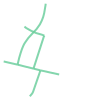

In [186]:
graph